In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import copy
import math
import numpy as np
import glob
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass
import itertools


## Model

In [2]:
torch.manual_seed(1337)
random.seed(1337)

In [3]:
def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    # elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    #     device = 'mps'
    print(f'using {device}')
    return device

DEVICE = get_device()

using cpu


In [4]:
class RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=2048):
        super().__init__()
        # Ensure dim is the head dimension, not the full embedding dimension
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        t = torch.arange(max_seq_len).type_as(inv_freq)
        freqs = torch.outer(t, inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer('emb', emb)

    def forward(self, x):
        # x: [Batch, Seq, Dim]
        # We only care about the sequence length here
        n = x.shape[1]
        # Returns [Seq, Head_Dim]
        return self.emb[:n, :].cos(), self.emb[:n, :].sin()

def apply_rotary_pos_emb(q, k, cos, sin):
    # q, k: [Batch, Heads, Seq, Head_Dim]
    # cos, sin: [Seq, Head_Dim] -> reshape to [1, 1, Seq, Head_Dim]
    
    cos = cos.unsqueeze(0).unsqueeze(0)
    sin = sin.unsqueeze(0).unsqueeze(0)

    # Standard RoPE rotation logic
    # split last dim into half
    q_d = q.shape[-1] // 2
    k_d = k.shape[-1] // 2
    
    q1, q2 = q[..., :q_d], q[..., q_d:]
    k1, k2 = k[..., :k_d], k[..., k_d:]
    
    q_rotated = torch.cat((-q2, q1), dim=-1)
    k_rotated = torch.cat((-k2, k1), dim=-1)
    
    q_out = (q * cos) + (q_rotated * sin)
    k_out = (k * cos) + (k_rotated * sin)
    
    return q_out, k_out

class BioMultiHeadAttention(nn.Module):
    # mirrors nn.MultiheadAttention(dim, heads, batch_first=True) 
    def __init__(self, config):
        super().__init__()
        assert config.embed_dim % config.heads == 0
        
        self.head_dim = config.embed_dim // config.heads
        self.heads = config.heads
        self.embed_dim = config.embed_dim
        
        # Projections
        self.q_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.k_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.v_proj = nn.Linear(config.embed_dim, config.embed_dim)
        
        self.c_proj = nn.Linear(config.embed_dim, config.embed_dim)

    def forward(self, x, cos, sin):
        B, T, C = x.size() # Batch, Seq, Embed Dim
        
        # 1. Project
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        # 2. Reshape for multi-head attention
        # (B, T, nh, hs) -> (B, nh, T, hs)
        q = q.view(B, T, self.heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.heads, self.head_dim).transpose(1, 2)

        # 3. Apply RoPE to Q and K (Rotary is applied per head)
        q, k = apply_rotary_pos_emb(q, k, cos, sin)

        # 4. Attention
        # is_causal=False because this is a bidirectional encoder
        y = F.scaled_dot_product_attention(q, k, v, is_causal=False)
        
        # 5. Reassemble
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        
        return y


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.embed_dim, int(config.mlp_ratio * config.embed_dim))
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(int(config.mlp_ratio * config.embed_dim), config.embed_dim)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class PathwayBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.embed_dim)
        self.attn = BioMultiHeadAttention(config)
        self.ln_2 = nn.LayerNorm(config.embed_dim)
        self.mlp = MLP(config)

    def forward(self, x, cos, sin):
        # 1. Attention with RoPE
        x_norm = self.ln_1(x)
        # Pass cos/sin into attn to be applied to Q/K
        attn_out = self.attn(x_norm, cos, sin)
        x = x + attn_out

        # 2. MLP
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class PathwayEncoderConfig:
    num_pathways: int = 1024 
    n_layer: int = 24 
    heads: int = 12
    embed_dim: int = 768
    mlp_ratio: float = 4.0 # Changed to float for precision

class PathwayEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            # input projects to embedding
            input_proj = nn.Linear(1, config.embed_dim),
            
            # RoPE needs the HEAD dimension, not the full embedding dimension
            rope = RotaryEmbedding(config.embed_dim // config.heads),
            
            # transformer block
            blocks = nn.ModuleList([PathwayBlock(config) for _ in range(config.n_layer)]),
            
            # final layer norm
            ln_f = nn.LayerNorm(config.embed_dim) 
        ))

        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
        
    def forward(self, x):
        # x: [Batch, Num_Pathways]
        x = x.unsqueeze(-1) # [B, N, 1]
        x = self.transformer.input_proj(x) # [B, N, Dim]
        
        # Generate RoPE cache
        # cos, sin are [Seq, Head_Dim]
        cos, sin = self.transformer.rope(x)
        cos, sin = cos.to(x.device), sin.to(x.device)
        
        for block in self.transformer.blocks:
            x = block(x, cos, sin)
            
        x = self.transformer.ln_f(x)

        return x

class AdaLN(nn.Module):
    '''
    Adaptive Layer Norm for conditioning the predictor on action embeddings.
    The action vector regresses the Scale (gamma) and Shift (beta) of the normalization.
    '''
    def __init__(self, embed_dim, action_embed_dim):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim, elementwise_affine=False)
        self.action_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(action_embed_dim, 2 * embed_dim)
        )
        # Initialize to identity (gamma=0, beta=0 originally, effectively gamma=1 after logic)
        # Zero-init the last layer so the action starts as a "no-op" (identity)
        nn.init.zeros_(self.action_mlp[1].weight)
        nn.init.zeros_(self.action_mlp[1].bias)

    def forward(self, x, action_emb):
        # x: [Batch, Seq, Dim]
        # action_emb: [Batch, action_embed_dim]
        
        # Project action to style: [B, 2*D] -> [B, 1, 2*D]
        style = self.action_mlp(action_emb).unsqueeze(1) 
        gamma, beta = style.chunk(2, dim=-1)
        
        # Apply affine transformation based on action
        return self.norm(x) * (1 + gamma) + beta

class PredictorBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        # 1. Conditioning (AdaLN) replaces standard LayerNorm
        self.ada_ln1 = AdaLN(config.embed_dim, config.action_embed_dim)
        
        # 2. Attention (Using the shared BioMultiHeadAttention)
        self.attn = BioMultiHeadAttention(config)
        
        # 3. Conditioning (AdaLN) for the MLP block
        self.ada_ln2 = AdaLN(config.embed_dim, config.action_embed_dim)
        
        # 4. MLP (Using the shared MLP)
        self.mlp = MLP(config)

    def forward(self, x, action_emb, cos, sin):
        # 1. AdaLN -> Attention (with internal RoPE) -> Residual
        x_norm = self.ada_ln1(x, action_emb)
        
        # Note: BioMultiHeadAttention handles q/k/v projection and apply_rotary_pos_emb internally
        attn_out = self.attn(x_norm, cos, sin)
        x = x + attn_out
        
        # 2. AdaLN -> MLP -> Residual
        x_norm = self.ada_ln2(x, action_emb)
        x = x + self.mlp(x_norm)
        
        return x

@dataclass
class ACPredictorConfig:
    num_pathways: int = 1024
    n_layer: int = 6 
    heads: int = 4
    embed_dim: int = 384
    action_embed_dim: int=256 
    mlp_ratio: float = 4.0
    max_perturb: int= 2058 ## eventually try to get to a 2**N power

class ACPredictor(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Action Embedding (Discrete ID -> Vector)
        self.action_embed = nn.Embedding(config.max_perturb, config.action_embed_dim)
        
        # Learnable Queries ("Mask Tokens") for the future state
        # One query vector per pathway position
        self.mask_queries = nn.Parameter(torch.randn(1, config.num_pathways, config.embed_dim) * 0.02)
        
        # RoPE: initialized with HEAD dimension (dim // heads)
        head_dim = config.embed_dim // config.heads
        self.rope = RotaryEmbedding(head_dim)
        
        self.blocks = nn.ModuleList([
            PredictorBlock(config) for _ in range(config.n_layer)
        ])
        
        self.final_norm = AdaLN(config.embed_dim, config.action_embed_dim)
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)

    def forward(self, context_latents, action_ids):
        """
        context_latents: [Batch, N, Dim] (From Student Encoder)
        action_ids: [Batch] (Ints)
        """
        B, N, D = context_latents.shape
        
        # 1. Embed Action
        action_emb = self.action_embed(action_ids) # [B, action_embed_dim]
        
        # 2. Construct Input: [Context, Mask_Queries]
        # We concatenate the learned queries to the context. 
        # The predictor will attend to the context to update the queries.
        queries = self.mask_queries.repeat(B, 1, 1) # [B, N, D]
        sequence = torch.cat([context_latents, queries], dim=1) # [B, 2N, D]
        
        # 3. Generate RoPE for the full sequence (2N)
        # cos, sin are [2N, Head_Dim]
        cos, sin = self.rope(sequence)
        cos, sin = cos.to(sequence.device), sin.to(sequence.device)
        
        # 4. Pass through AdaLN Blocks
        for block in self.blocks:
            sequence = block(sequence, action_emb, cos, sin)
            
        sequence = self.final_norm(sequence, action_emb)
        
        # 5. Return only the predicted part (The Queries corresponding to N..2N)
        predictions = sequence[:, N:, :] 
        return predictions

@dataclass
class BioJepaConfig:
    num_pathways: int = 1024
    n_layer: int = 6 
    heads: int = 4
    embed_dim: int = 256
    action_embed_dim: int=256 
    mlp_ratio: float = 4.0
    max_perturb: int= 2058 ## eventually try to get to a 2**N power
    
class BioJepa(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.student = PathwayEncoder(PathwayEncoderConfig(
            num_pathways = config.num_pathways,
            n_layer= config.n_layer, 
            heads=config.heads, 
            embed_dim= config.embed_dim
        ))
                                      
        self.teacher = copy.deepcopy(self.student)
        
        # Freeze teacher
        for p in self.teacher.parameters():
            p.requires_grad = False
            
        self.predictor = ACPredictor(ACPredictorConfig(
            n_layer=config.n_layer, 
            heads=config.heads, 
            embed_dim=config.embed_dim, 
            action_embed_dim=config.action_embed_dim,
            num_pathways=config.num_pathways
        ))
        
    def forward(self, x_control, x_treated, action_id):
        # 1. Teacher
        with torch.no_grad():
            target_latents = self.teacher(x_treated)
            
        # 2. Student 
        context_latents = self.student(x_control)
        
        # 3. Predictor 
        predicted_latents = self.predictor(context_latents, action_id)
        
        # 4. Latent Loss (L1)
        loss = F.l1_loss(predicted_latents, target_latents)
        
        return loss

    @torch.no_grad()
    def update_teacher(self, m=0.996):
        for param_s, param_t in zip(self.student.parameters(), self.teacher.parameters()):
            param_t.data.mul_(m).add_((1 - m) * param_s.data)

In [5]:
BATCH_SIZE = 256
n_embd = 128
n_pathways = 1024
LR = 3e-4
EPOCHS = 15
tok_file_chunk_size = 10000

## Data Loading and Model instantiation

In [6]:
data_dir = Path('/Users/djemec/data/jepa')
checkpoint_dir = data_dir / 'checkpoint'
val_dir = data_dir / 'tokenized' / 'val'
metadata_path = data_dir / 'perturbation_map.json'

In [7]:
model = BioJepa(BioJepaConfig(
    num_pathways=n_pathways,
    embed_dim = n_embd
)).to(DEVICE)

## Checkpoint Loading

In [8]:
# 3. Load Checkpoint
# Your script saves a dict: {'model': ..., 'optimizer': ..., 'step': ...}
checkpoint_path = checkpoint_dir / 'bio_jepa_ckpt_17550_final.pt'
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

keys = model.load_state_dict(checkpoint['model'])

In [9]:
with open(metadata_path, "r") as f:
    pert_map = json.load(f)
# Invert map to: ID -> Name
id_to_name = {v: k for k, v in pert_map.items()}

## Validation

In [10]:
val_file = sorted(val_dir.glob('*.npz'))
val_file

[PosixPath('/Users/djemec/data/jepa/tokenized/val/shard_0000.npz')]

In [28]:
with np.load(val_file[0]) as data:
    # Extract raw uint32
    all_control_raw = data['control']
    all_case_raw = data['case']
    all_act_id = data['action_ids']

In [29]:
examples_to_validate = 100000
validation = {}
total_examples = len(all_act_id)

In [30]:
model.eval()

for i in range(examples_to_validate):
    # pick a random index out 
    idx = np.random.randint(total_examples)

    # extract inputs for the index
    x_control = torch.tensor(all_control_raw[idx].astype(np.float32)).unsqueeze(0).to(DEVICE) # [1, 1024]
    x_case = torch.tensor(all_case_raw[idx].astype(np.float32)).unsqueeze(0).to(DEVICE)
    action_id = torch.tensor([all_act_id[idx]], dtype=torch.long).to(DEVICE)

    # get perturbation name
    pert_name = id_to_name[action_id.item()]

    # run teacher
    with torch.no_grad():
        z_control = model.teacher(x_control)       # Where the cell started
        z_case = model.teacher(x_case)     # Where the cell actually went

    # run student and predictor
    with torch.no_grad():
        z_context = model.student(x_control)
        z_predicted = model.predictor(z_context, action_id) # Where the model thinks it went

    drift = F.l1_loss(z_control, z_case).item()
    error = F.l1_loss(z_predicted, z_case).item()
    sim_move = F.l1_loss(z_control,z_predicted).item()

    improvement = (1 - (error / drift))
    if i % int(examples_to_validate*.1) == 0:
        print(f'step {i}')
        #print(f'drift {drift} | error: {error} | sim_move {sim_move}')
        print(f'for id {idx}, perturbation {pert_name} prediction is {improvement:.1f}% closer to the truth than the Control state was.')

    validation[idx] = {
        'perturbation': pert_name,
        'error': error,
        'drift': drift,
        'improvement': improvement,
        'sim_move': sim_move
    }
    

step 0
for id 3390, perturbation STAT5A prediction is 0.4% closer to the truth than the Control state was.
step 10000
for id 1648, perturbation EIF4G1 prediction is 0.3% closer to the truth than the Control state was.
step 20000
for id 9874, perturbation TRAPPC4 prediction is 0.1% closer to the truth than the Control state was.
step 30000
for id 9336, perturbation PLEKHN1 prediction is 0.3% closer to the truth than the Control state was.
step 40000
for id 1333, perturbation CDC16 prediction is 0.1% closer to the truth than the Control state was.
step 50000
for id 3593, perturbation CPSF3 prediction is 0.1% closer to the truth than the Control state was.
step 60000
for id 6132, perturbation HSPA9 prediction is 0.2% closer to the truth than the Control state was.


KeyboardInterrupt: 

(array([2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 5.000e+00, 4.000e+00,
        2.000e+00, 4.000e+00, 3.000e+00, 1.100e+01, 7.000e+00, 1.400e+01,
        1.300e+01, 2.300e+01, 2.800e+01, 3.700e+01, 6.100e+01, 6.600e+01,
        1.200e+02, 1.500e+02, 2.890e+02, 4.410e+02, 6.930e+02, 8.220e+02,
        9.510e+02, 1.083e+03, 1.011e+03, 9.070e+02, 7.850e+02, 6.950e+02,
        5.370e+02, 4.420e+02, 3.090e+02, 2.160e+02, 1.250e+02, 8.100e+01,
        2.900e+01, 9.000e+00]),
 array([-1.19290611, -1.15580531, -1.1187045 , -1.0816037 , -1.04450289,
        -1.00740209, -0.97030128, -0.93320048, -0.89609968, -0.85899887,
        -0.82189807, -0.78479726, -0.74769646, -0.71059565, -0.67349485,
        -0.63639404, -0.59929324, -0.56219244, -0.52509163, -0.48799083,
        -0.45089002, -0.41378922, -0.37668841, -0.33958761, -0.30248681,
        -0.

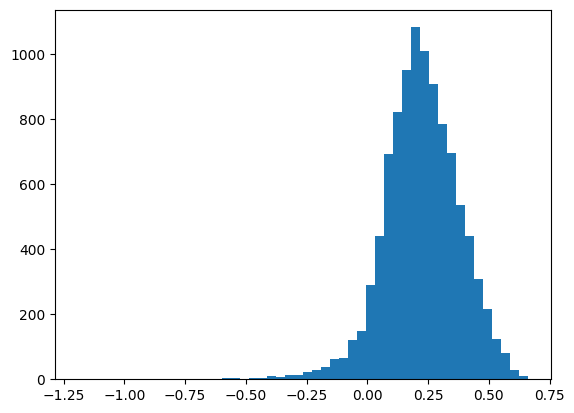

In [31]:
all_improves = [entry['improvement'] for entry in validation.values()]
plt.hist(all_improves, bins=50)

(array([ 13., 139., 345., 650., 826., 867., 851., 747., 654., 589., 486.,
        431., 353., 318., 269., 223., 192., 191., 170., 145., 135., 128.,
        118.,  90.,  92.,  93.,  80.,  72.,  69.,  57.,  71.,  50.,  60.,
         52.,  67.,  57.,  39.,  41.,  35.,  30.,  29.,  19.,  11.,  11.,
          5.,   5.,   1.,   2.,   1.,   2.]),
 array([0.14732005, 0.16420249, 0.18108493, 0.19796737, 0.21484981,
        0.23173225, 0.24861469, 0.26549713, 0.28237957, 0.29926201,
        0.31614445, 0.3330269 , 0.34990934, 0.36679178, 0.38367422,
        0.40055666, 0.4174391 , 0.43432154, 0.45120398, 0.46808642,
        0.48496886, 0.5018513 , 0.51873374, 0.53561618, 0.55249862,
        0.56938107, 0.58626351, 0.60314595, 0.62002839, 0.63691083,
        0.65379327, 0.67067571, 0.68755815, 0.70444059, 0.72132303,
        0.73820547, 0.75508791, 0.77197035, 0.7888528 , 0.80573524,
        0.82261768, 0.83950012, 0.85638256, 0.873265  , 0.89014744,
        0.90702988, 0.92391232, 0.94079476, 0.

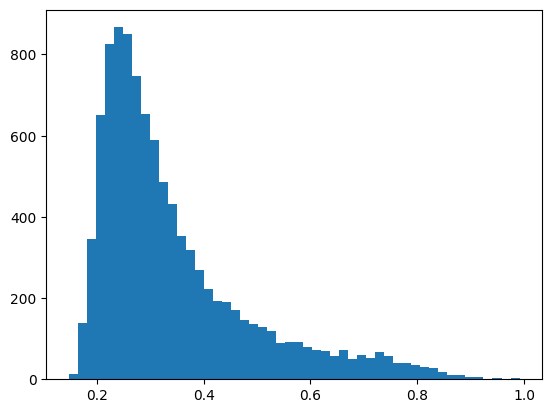

In [32]:
all_error = [entry['error'] for entry in validation.values()]
plt.hist(all_error, bins=50)